In [1]:
# some standard imports
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad as compute_grad   
from autograd.misc.flatten import flatten_func
from mlrefined_libraries import math_optimization_library as optlib
from datetime import datetime 

static_plotter = optlib.static_plotter.Visualizer();

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# Gradient descent

In [2]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

# Zero order coordinate descent

In [16]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
            
        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1))
            direction[c[n]] = 1
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(g(w))

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < g(w):
                # take step
                w = w + ((-1)**(ind))*alpha*direction
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

# load a face detection dataset

A dataset of size $P = 10,000$ face detection dataset (about 5K faces and non-face images).

In [4]:
# load in large-ish dataset
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

Lets take a random subset of 8,000 points for training.

In [5]:
# load in data - for this one split up training and testing
ind = np.random.permutation(len(data))
data_train = data[ind[:-1],:]
data_test = data[ind[-2000:],:]

In [6]:
x = data_train[:,:-1]
y = data_train[:,-1:]
num_pts = len(y)

# Cost functions

Nice compact cost function.

In [7]:
# the softmax cost function
def softmax(w):
    cost  = np.sum(np.log(1 + np.exp((-y)*(w[0] + np.dot(x,w[1:])))))
    return cost

In [8]:
scale = 0.1
w = scale*np.random.randn(np.shape(x)[1]+1,1)

In [13]:
# run standard (full) gradient descent
g = softmax
alpha_choice = 10**(-4); max_its = 725;

### time the run of random search
start_time = datetime.now() 

weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w)


time_elapsed = datetime.now() - start_time 
print('Time elapsed for random search run (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed for random search run (hh:mm:ss.ms) 0:00:36.666097


In [19]:
# run coordinate descent algorithm
g = softmax
alpha_choice = 2*10**(0); max_its = 1; 

### time the run of random search
start_time = datetime.now() 

weight_history_3, cost_history_3 = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

time_elapsed = datetime.now() - start_time 
print('Time elapsed for random search run (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed for random search run (hh:mm:ss.ms) 0:01:16.658029


<IPython.core.display.Javascript object>


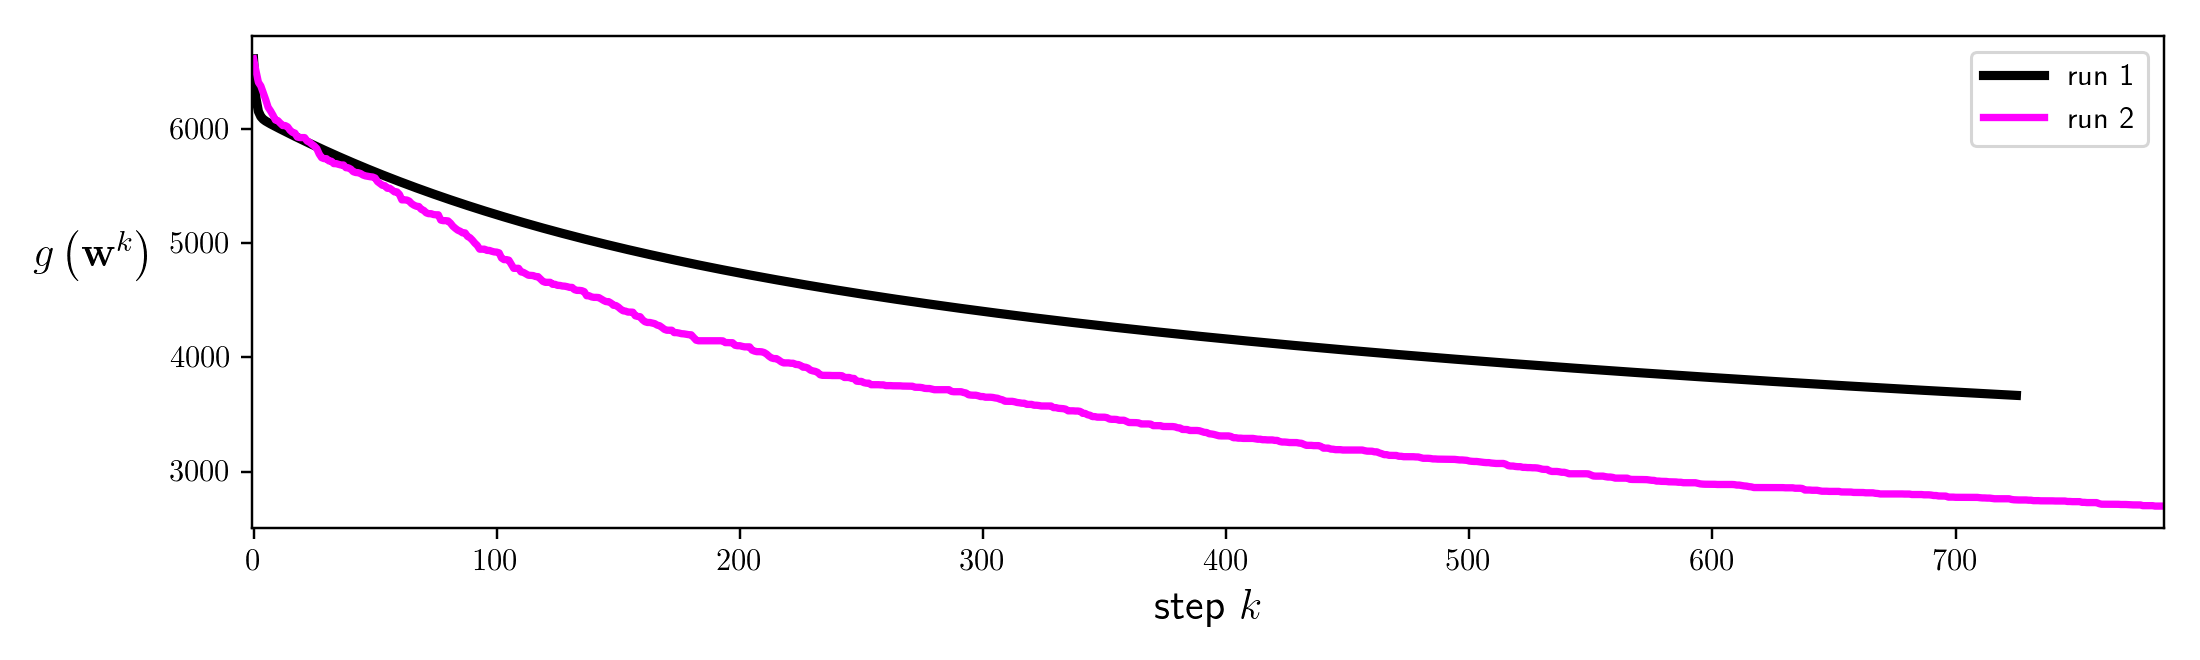

In [20]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_3],start = 0,points = False,labels = ['run 1','run 2'])

Yep - minibatch is pretty good!